# Bank Term Deposit Prediction - Binary Classification Project

In [1]:
# Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import shap
import joblib
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

In [3]:
# Load the uploaded dataset
file_path = "bank-additional-full.csv"
df = pd.read_csv(file_path, sep=';')

# Display basic info and first few rows
df_info = df.info()
df_head = df.head()

df_info, df_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

(None,
    age        job  marital    education  default housing loan    contact  \
 0   56  housemaid  married     basic.4y       no      no   no  telephone   
 1   57   services  married  high.school  unknown      no   no  telephone   
 2   37   services  married  high.school       no     yes   no  telephone   
 3   40     admin.  married     basic.6y       no      no   no  telephone   
 4   56   services  married  high.school       no      no  yes  telephone   
 
   month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
 0   may         mon  ...         1    999         0  nonexistent          1.1   
 1   may         mon  ...         1    999         0  nonexistent          1.1   
 2   may         mon  ...         1    999         0  nonexistent          1.1   
 3   may         mon  ...         1    999         0  nonexistent          1.1   
 4   may         mon  ...         1    999         0  nonexistent          1.1   
 
    cons.price.idx  cons.conf.idx  

In [4]:
missing_values = df.isnull().sum()
missing_values

,0
age,0
job,0
marital,0
education,0
default,0
housing,0
loan,0
contact,0
month,0
day_of_week,0


#### Наступний крок — проведення Exploratory Data Analysis (EDA):

Аналіз цільової змінної y.

Оцінка розподілу числових та категоріальних ознак.

Первинне виявлення потенційних закономірностей.

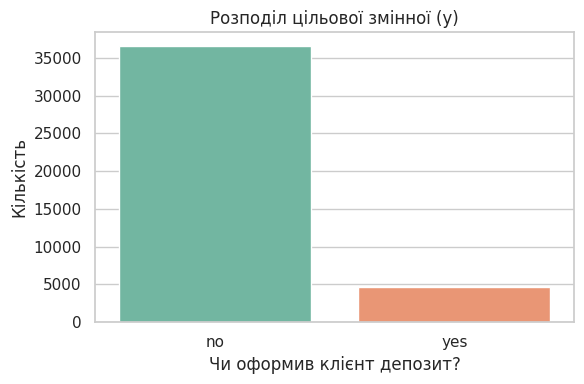

,proportion
y,
no,88.734583
yes,11.265417


In [5]:
# Set styles for visualization
sns.set(style="whitegrid")

# Target variable distribution
target_dist = df['y'].value_counts(normalize=True) * 100

# Plot target variable distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='y', hue='y', data=df, palette='Set2', legend=False)
plt.title('Розподіл цільової змінної (y)')
plt.ylabel('Кількість')
plt.xlabel('Чи оформив клієнт депозит?')
plt.tight_layout()
plt.show()

# Display percentage distribution
target_dist

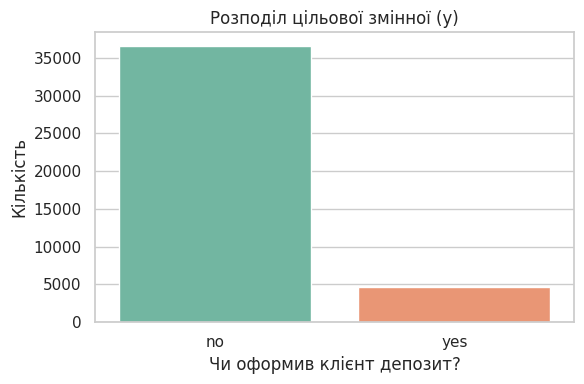

 *Результати аналізу цільової змінної y:*

- 88.7% клієнтів не оформили депозит (no)
- Лише 11.3% клієнтів підписали депозит (yes)

Це означає, що в нас є суттєвий дисбаланс класів, і це важливо враховувати при виборі метрик і моделюванні. Наприклад:

Accuracy не підходить як основна метрика (можна досягти >88% точності, передбачаючи завжди "no").

Краще орієнтуватися на F1-score, Precision/Recall, або AUROC.

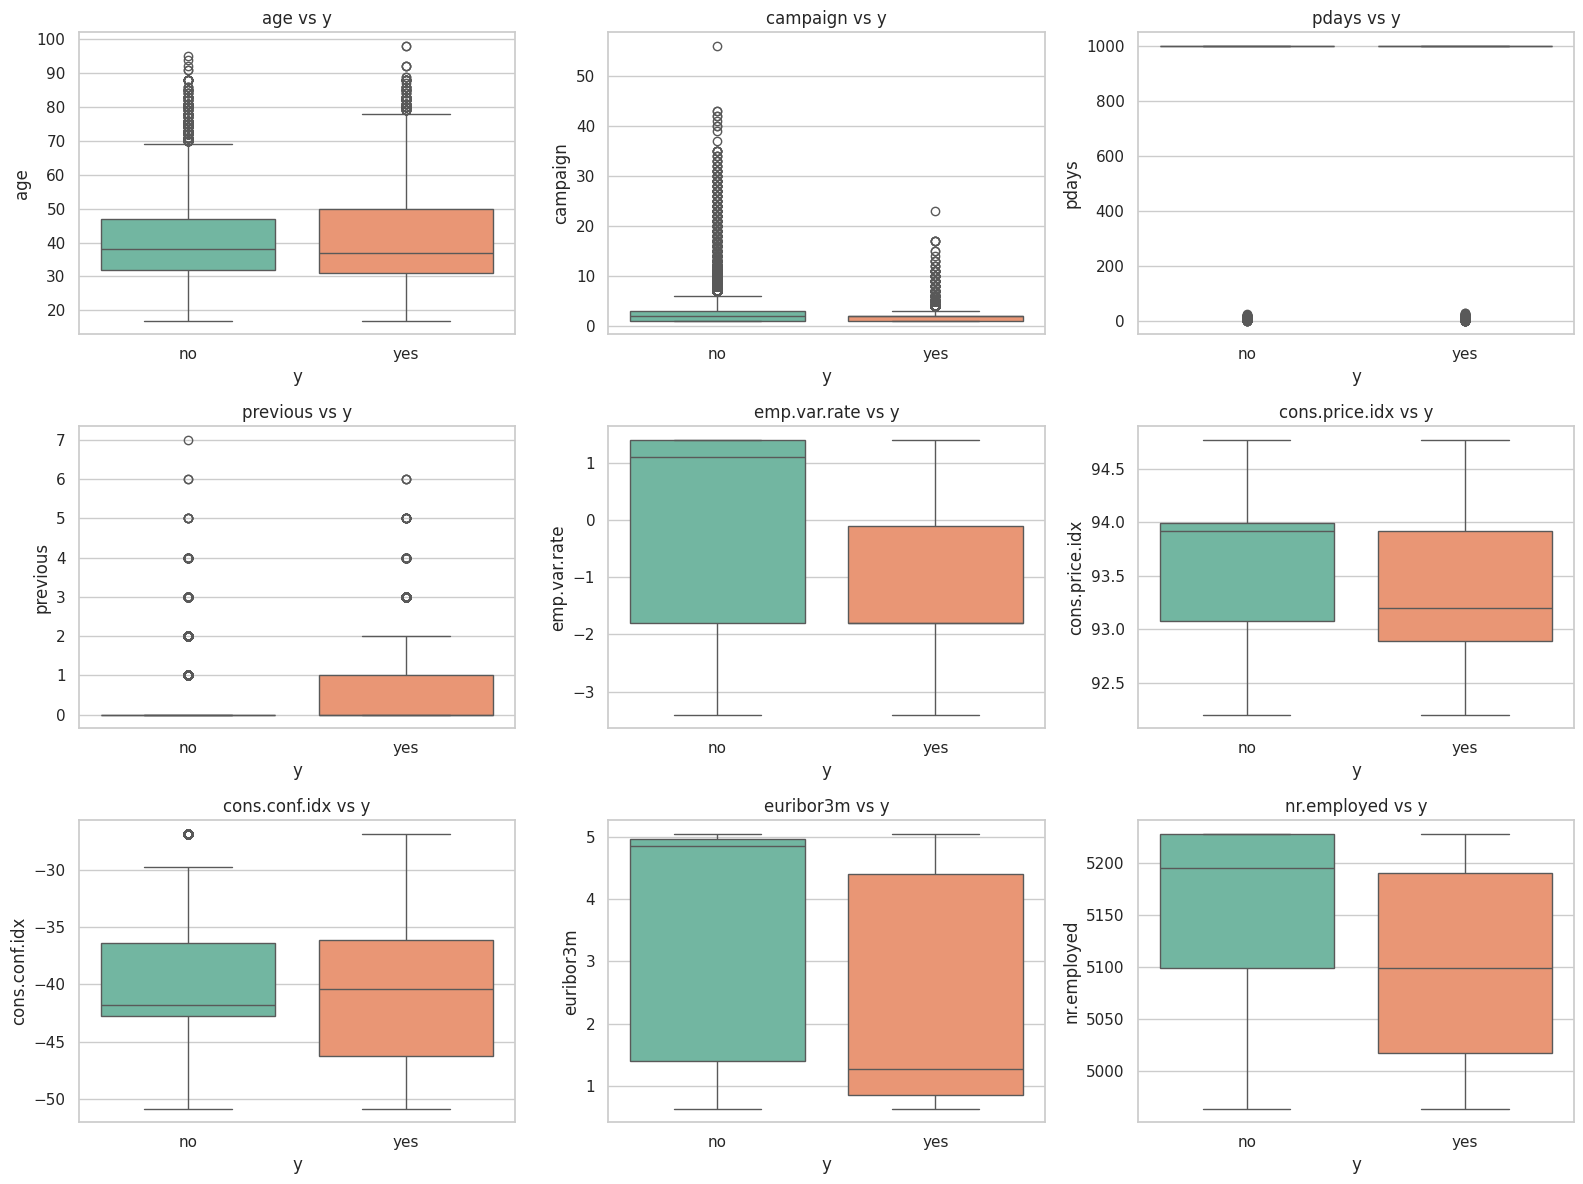

['age',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

In [6]:
# Select numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols.remove("duration")  # duration can't be used in the final model

# Plot distributions of numeric features grouped by target variable
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(data=df, x='y', y=col, hue='y', ax=axes[i], palette='Set2', legend=False)
    axes[i].set_title(f'{col} vs y')

plt.tight_layout()
plt.show()

numeric_cols

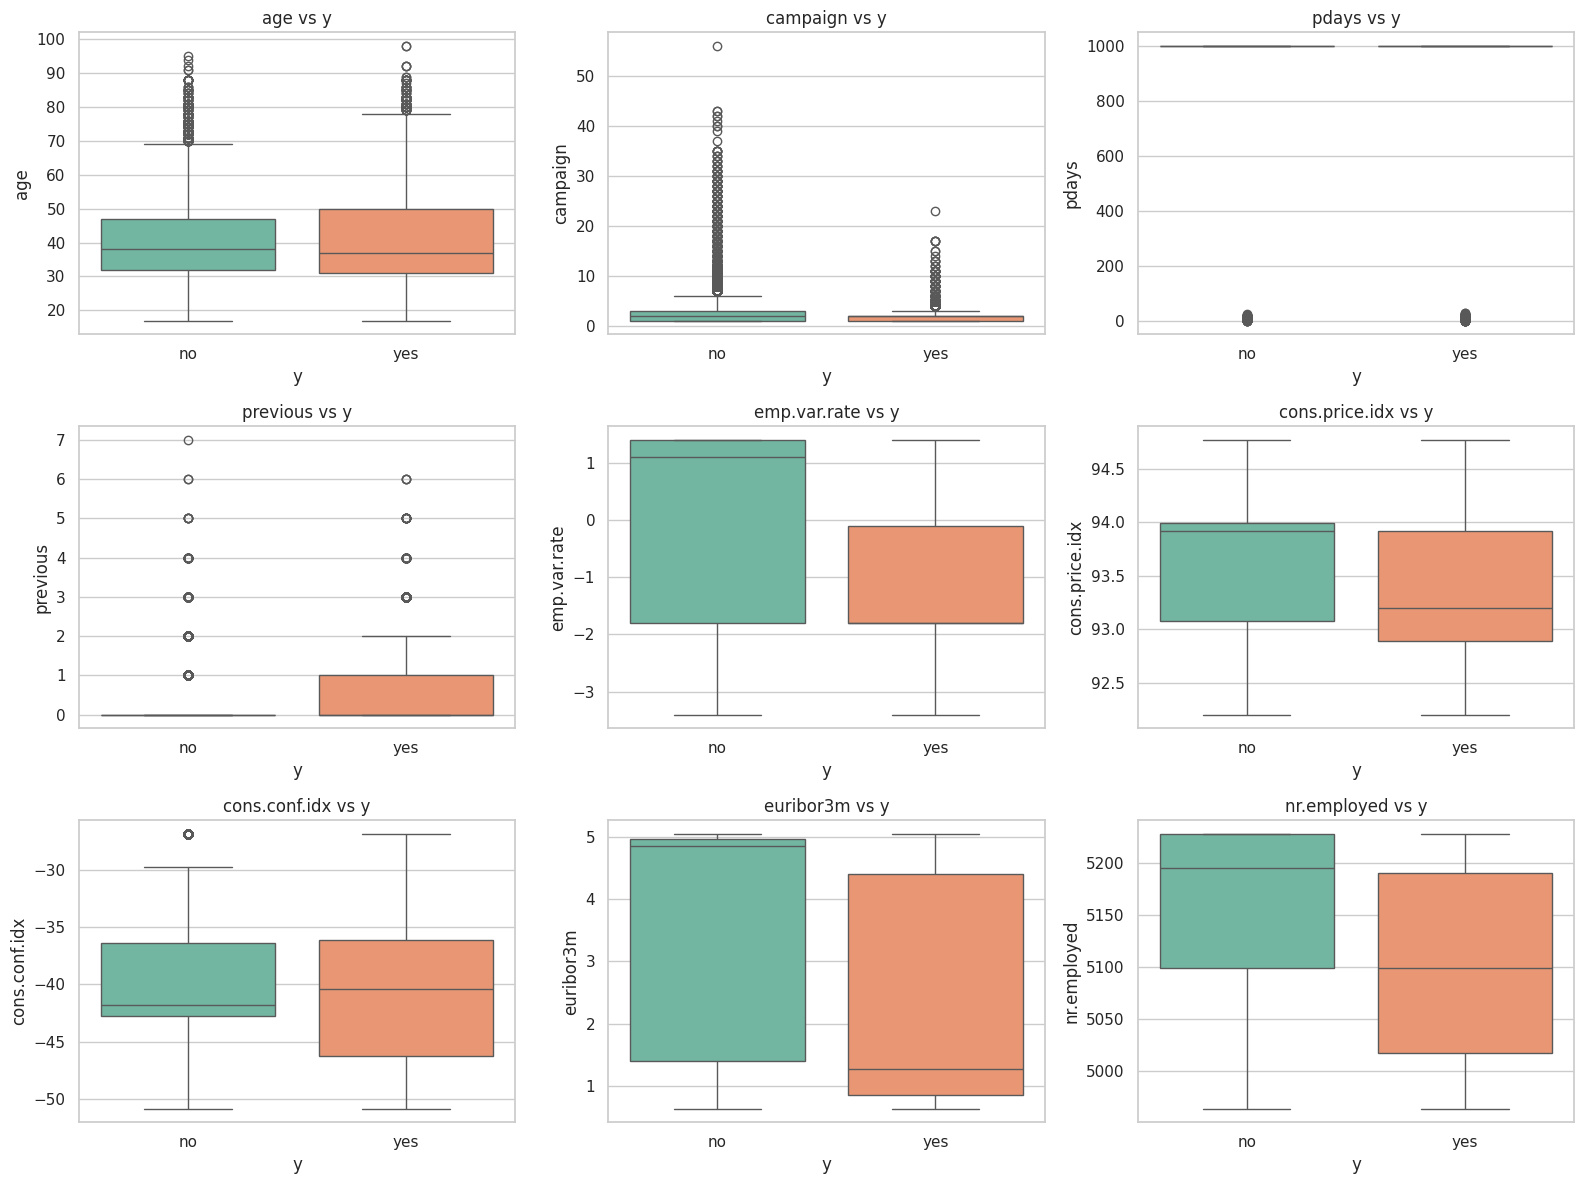

*Аналіз розподілу числових змінних залежно від цільової y:*

- age — клієнти, які підписали депозит, трохи старші в середньому.
- campaign — кількість контактів у кампанії зазвичай нижча для тих, хто погодився. Занадто багато дзвінків неефективні.
- pdays — дуже багато значень 999 (означає, що клієнт не контактувався раніше). Менші значення pdays частіше пов’язані з позитивним результатом.
- previous — більше попередніх контактів трохи збільшує шанс підписання.
- emp.var.rate, euribor3m, nr.employed — вищі економічні показники (наприклад, ставка Euribor) асоціюються з нижчою ймовірністю оформлення депозиту (можливо, люди мають інші інвестиційні опції).
- cons.price.idx, cons.conf.idx — видно невеликі зміщення, але їх вплив потребує подальшого аналізу.

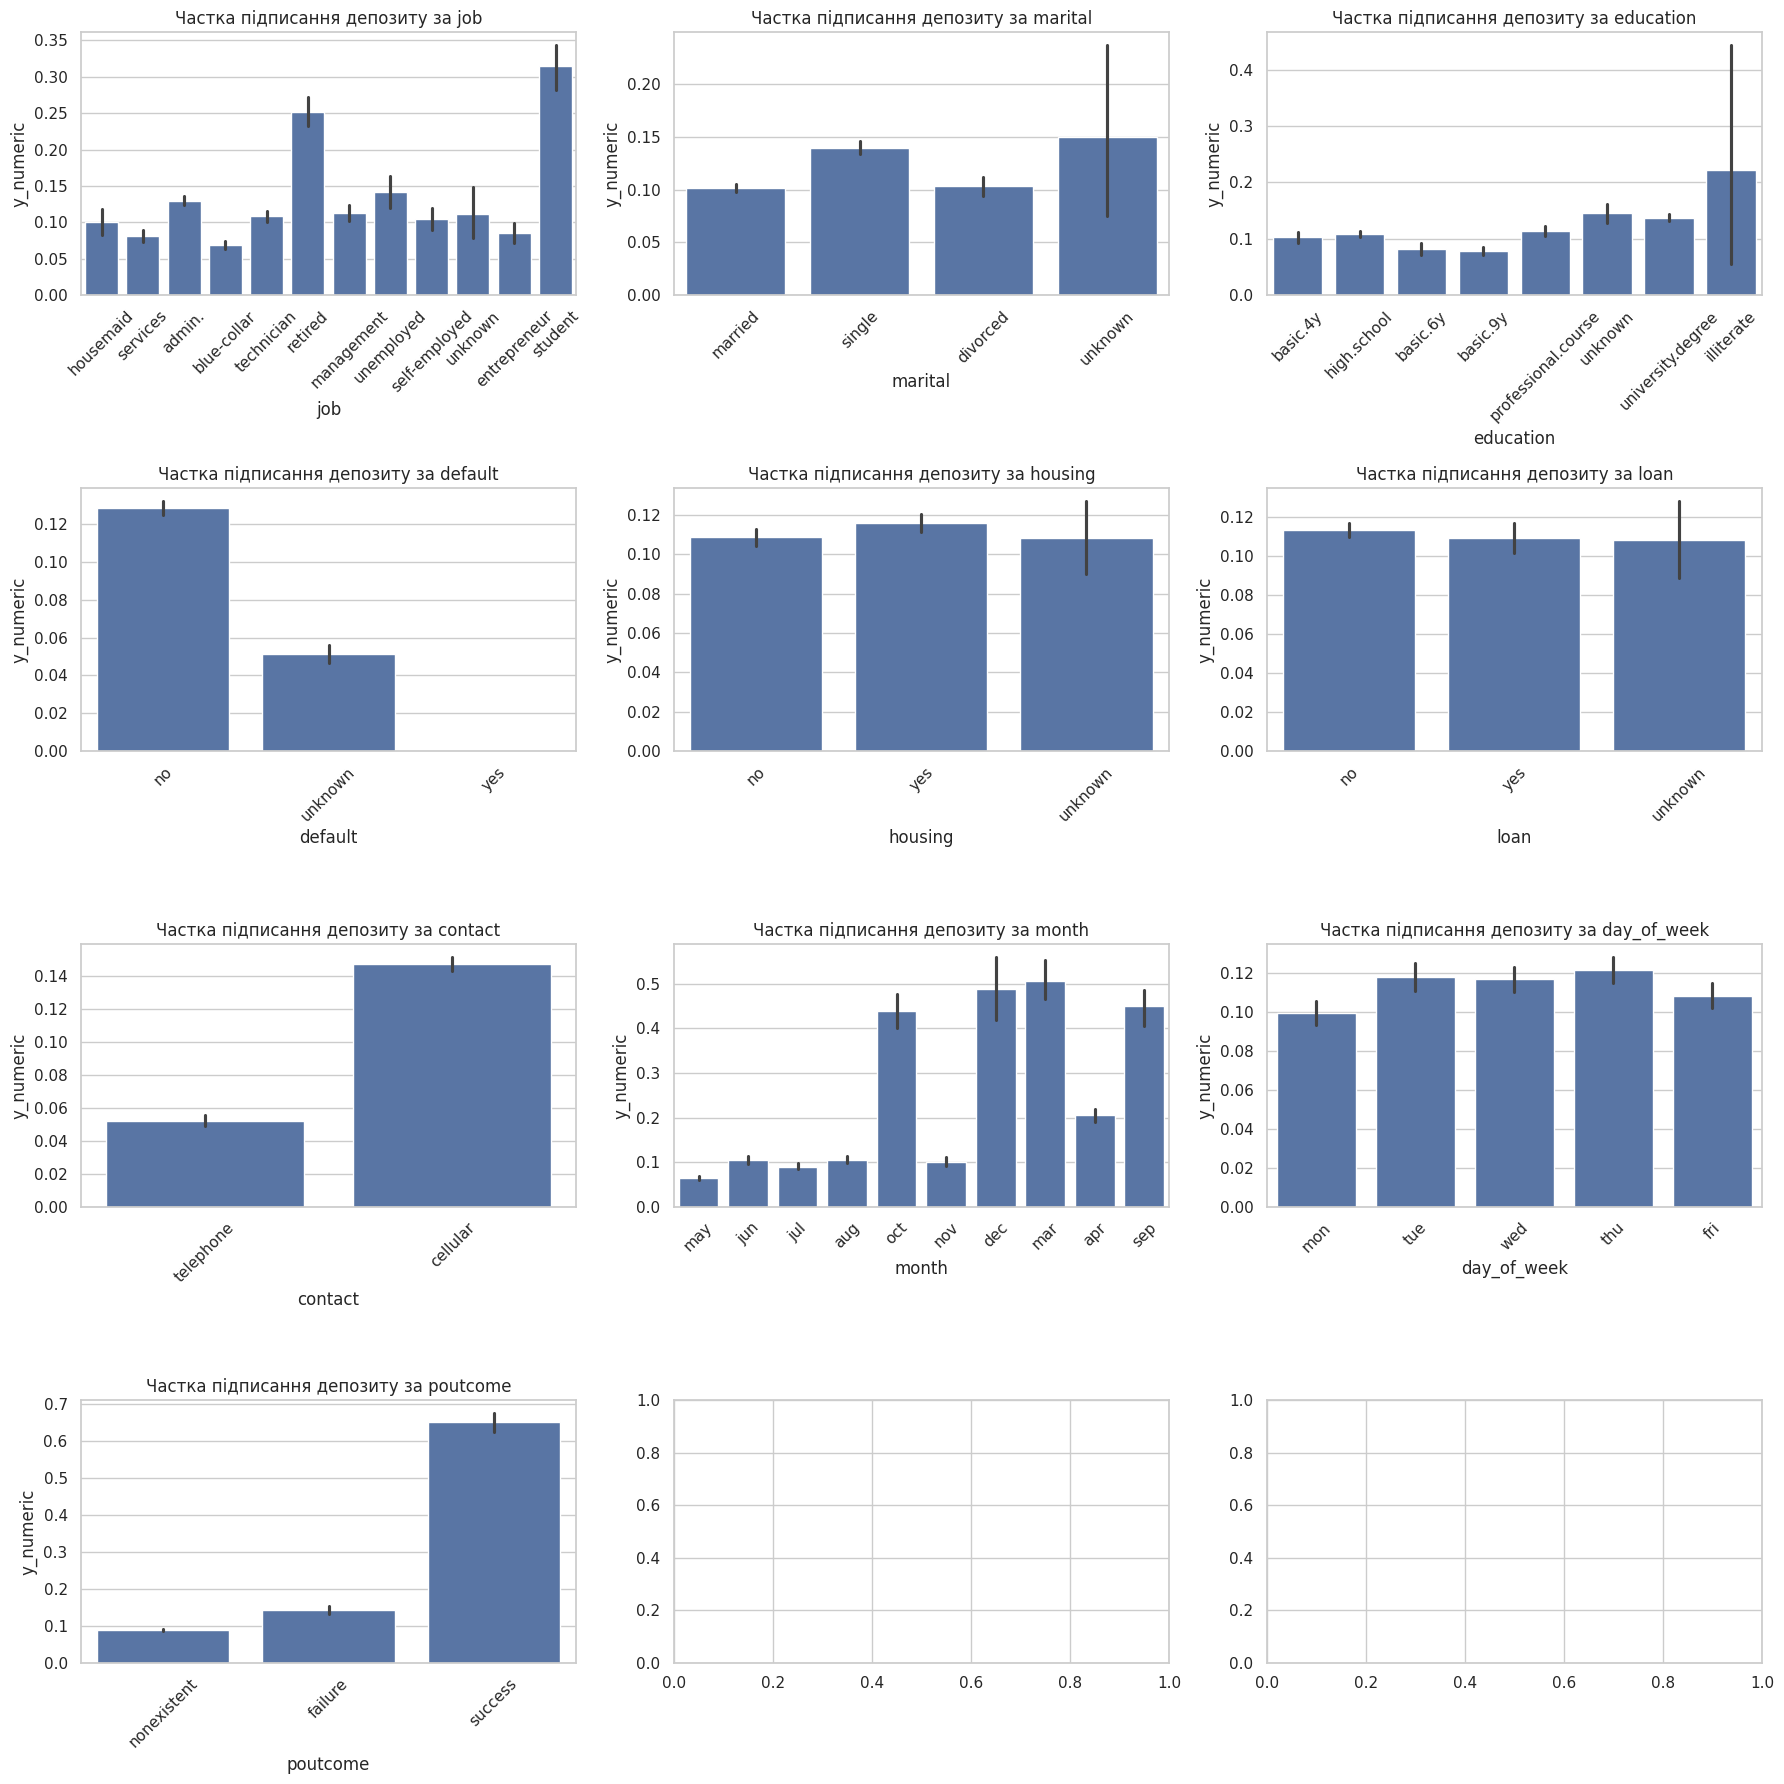

In [7]:
# Selecting categorical variables
categorical_cols = df.select_dtypes(include='object').columns.drop('y')

# Plotting distribution graphs of the target variable for each categorical feature
df_copy = df.copy()
df_copy['y_numeric'] = df_copy['y'].map({'no': 0, 'yes': 1})

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 18))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.barplot(x=col, y='y_numeric', data=df_copy, ax=axes[i])
    axes[i].set_title(f'Частка підписання депозиту за {col}')
    axes[i].tick_params(axis='x', rotation=45)


plt.tight_layout()
plt.show()

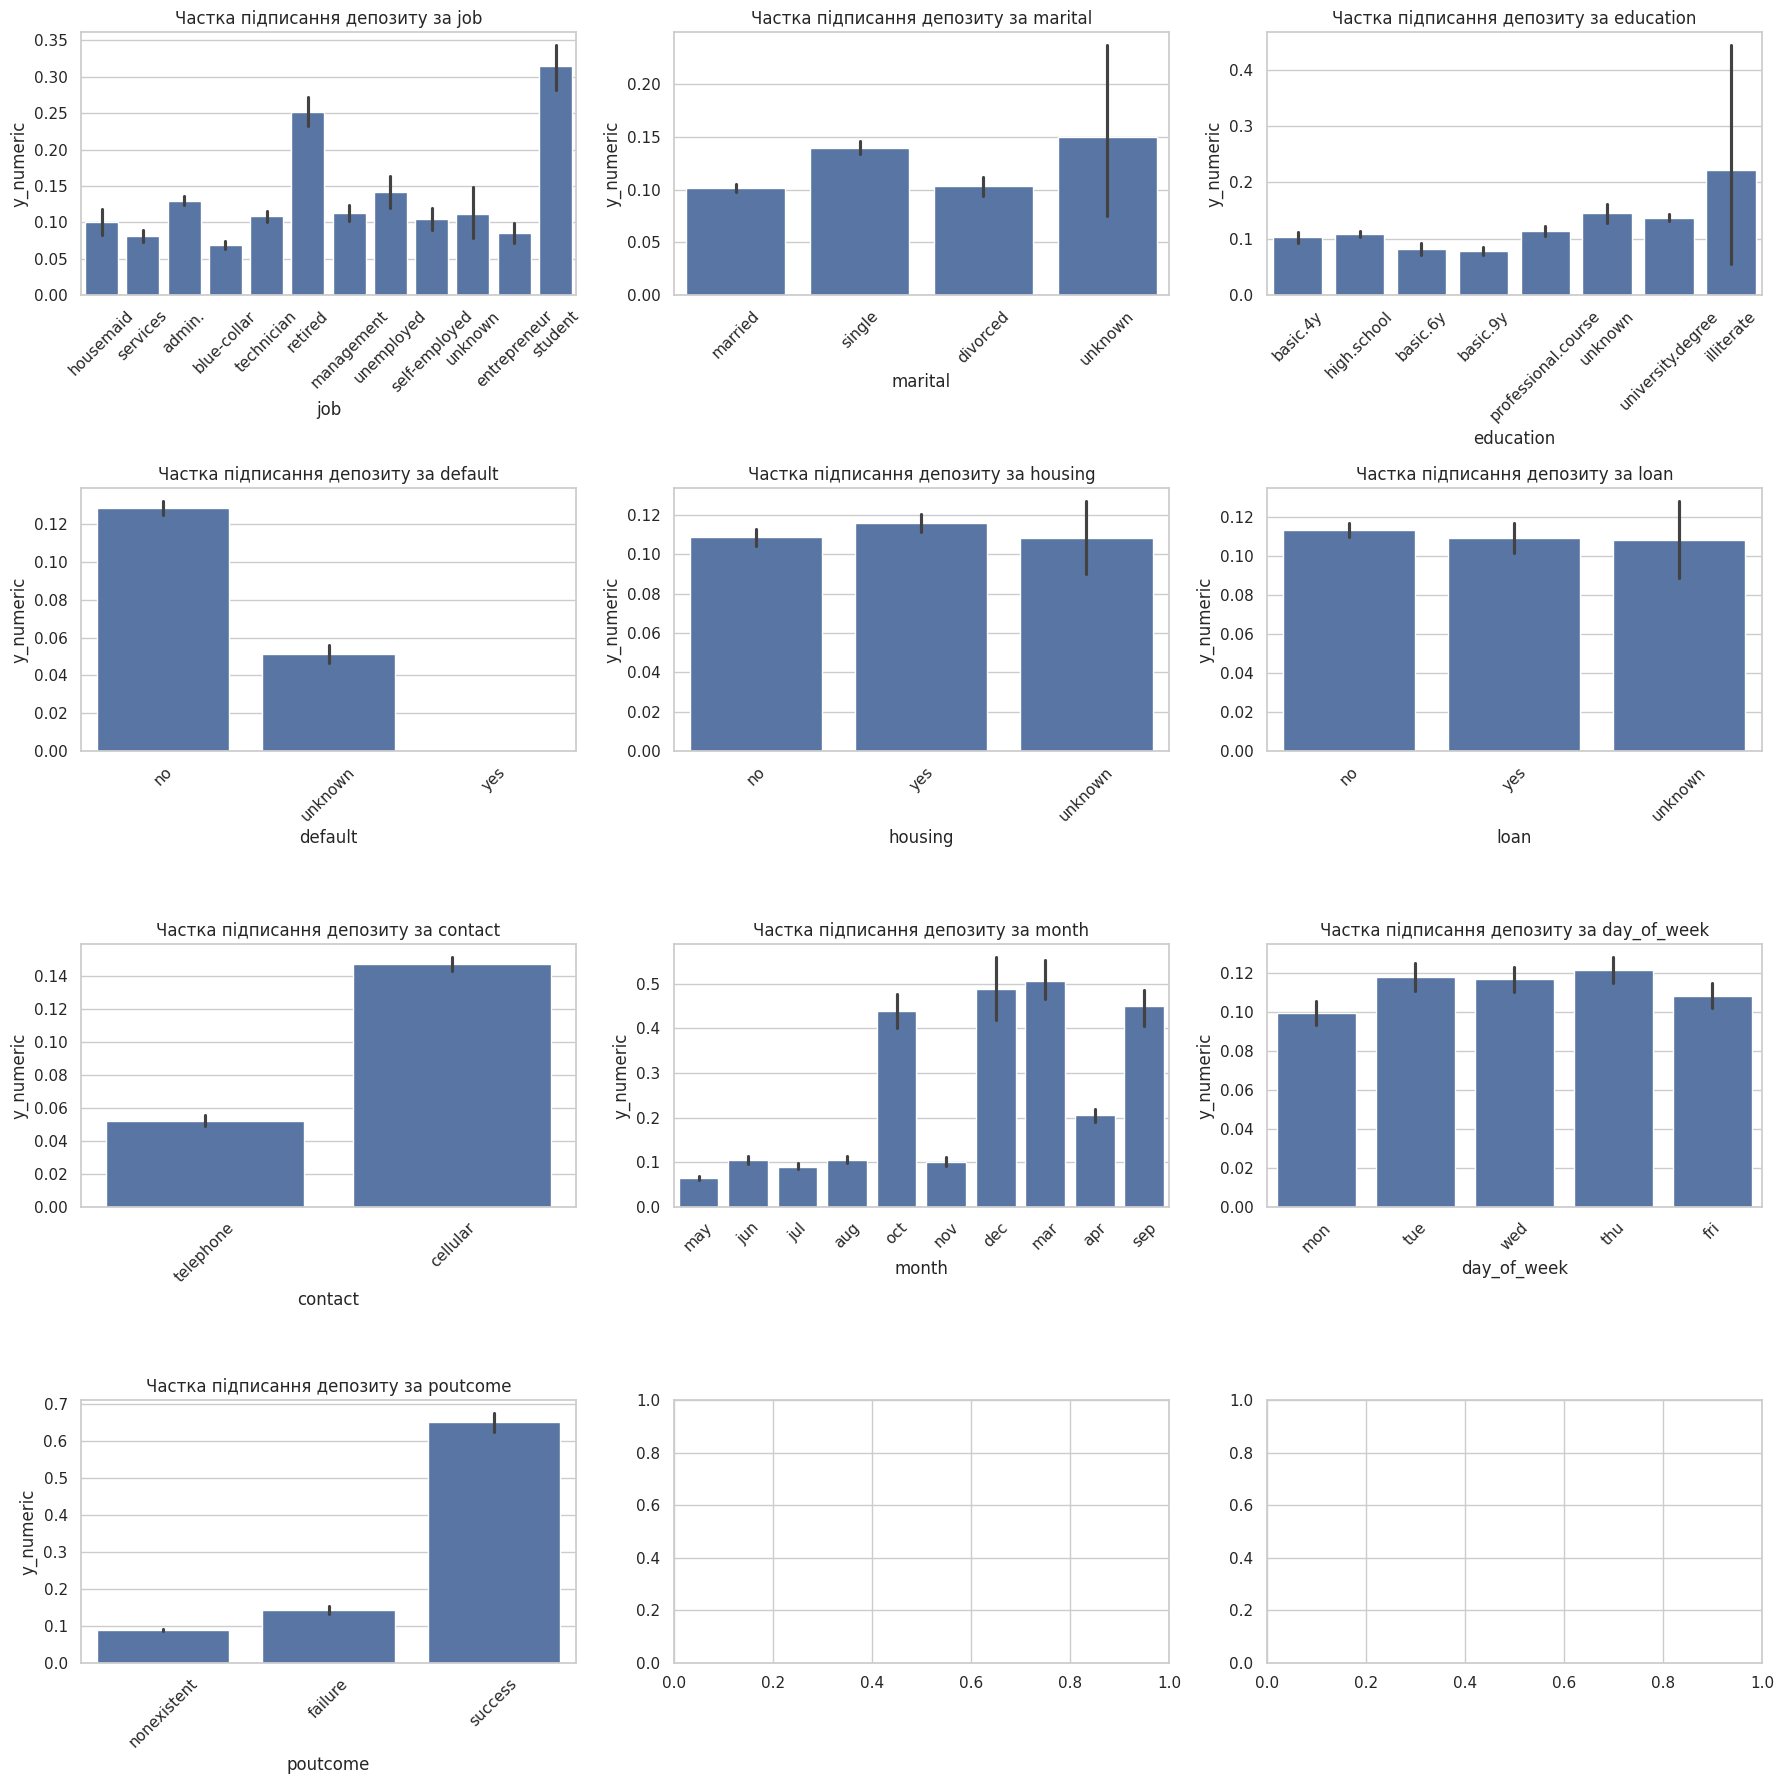

*Висновки щодо категоріальних змінних:*
- job — найбільш схильні до підписання депозиту: пенсіонери (retired), студенти (student) і безробітні (unemployed). Найменше — blue-collar.
- marital — клієнти без партнера (single) більш охоче підписують депозит, ніж одружені (married).
- education — вища освіта (university.degree, professional.course) сприяє вищій ймовірності підписання.
- default — ті, у кого є прострочений кредит, майже не підписують депозит.
- housing та loan — клієнти без іпотеки чи споживчого кредиту частіше погоджуються.
- contact — дзвінки на мобільний (cellular) мають набагато вищу ефективність.
- month — may, jul, aug - дуже низька конверсія, а от mar, oct, dec показують кращі результати.
- day_of_week — розбіжності мінімальні, але mon і thu дещо ефективніші.
- poutcome — якщо попередня кампанія була успішною (success), ймовірність зростає у кілька разів.

Для задачі бінарної класифікації ми використаємо 4 різні типи моделей, кожна з яких має свої переваги:

| Модель                              | Причина вибору                                                                                |
| ----------------------------------- | --------------------------------------------------------------------------------------------- |
| **Logistic Regression**             | Базова інтерпретована модель, добре підходить для лінійно відокремлюваних ознак               |
| **kNN (k-Nearest Neighbors)**       | Нелінійна модель, базується на локальній подібності — хороша як контраст до лінійної регресії |
| **Decision Tree**                   | Дає інтерпретовану структуру рішень, гарна для виявлення важливих ознак                       |
| **Boosting (XGBoost)** | Модель, що добре працює з табличними даними і складними взаємозв’язками               |



Через дисбаланс класів (88.7% "no", 11.3% "yes"), стандартна accuracy буде шкідливою метрикою. Замість неї обираємо:

| Метрика       | Пояснення                                                                                         |
| ------------- | ------------------------------------------------------------------------------------------------- |
| **F1-score**  | Баланс precision і recall — критично важливо, щоб не пропускати потенційних клієнтів              |
| **Precision** | Важливо не нав’язувати депозит тим, хто не погодиться (маркетингові витрати)                      |
| **Recall**    | Важливо охопити всіх, хто може погодитися                                                         |
| **AUROC**     | Показує здатність моделі розділяти класи незалежно від порогу — корисна для загального ранжування |


Ми використовуватимемо F1-score як основну метрику, і доповнюватимемо її AUROC.

#### Preprocessing

In [8]:
# Скопіюємо датафрейм для подальшої обробки
df_clean = df.copy()

# Видаляємо ознаку 'duration' — її не можна використовувати у продакшн-моделі
df_clean.drop(columns=['duration'], inplace=True)

# Кодуємо цільову змінну: 'yes' → 1, 'no' → 0
df_clean['y'] = df_clean['y'].map({'yes': 1, 'no': 0})

# Перевіримо кількість "невідомих"/"unknown" значень у категоріальних ознаках
unknown_counts = df_clean[categorical_cols].apply(lambda col: (col == 'unknown').sum()).sort_values(ascending=False)

unknown_counts

,0
default,8597
education,1731
housing,990
loan,990
job,330
marital,80
contact,0
month,0
day_of_week,0
poutcome,0


Unknown-значення:
- default	залишимо як окрему категорію — це важлива ознака
- education	можна створити категорію 'unknown' явно
- housing та loan	залишимо як є — ймовірно, відображають відсутність даних
- job, marital	залишимо як окрему категорію (не видаляємо, бо втрата даних незначна)

In [9]:
# Копія для трансформацій
df_model = df_clean.copy()

# 1. Створюємо нову ознаку: чи був контакт до цього
df_model['prev_contacted'] = (df_model['pdays'] != 999).astype(int)

# 2. Групування та спрощення категорій робити не будемо

# 3. One-hot encoding для категоріальних ознак
categorical_to_encode = ['job', 'marital', 'education', 'default', 'housing', 'loan',
                         'contact', 'month', 'day_of_week', 'poutcome']

df_model = pd.get_dummies(df_model, columns=categorical_to_encode, drop_first=True)

# 4. Масштабування числових ознак
numeric_to_scale = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
                    'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

scaler = StandardScaler()
df_model[numeric_to_scale] = scaler.fit_transform(df_model[numeric_to_scale])

# Перевіримо фінальний розмір та перші рядки
df_model.shape

(41188, 54)

In [10]:
df_model.head()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,...,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,1.533034,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,0,...,True,False,False,False,True,False,False,False,True,False
1,1.628993,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,0,...,True,False,False,False,True,False,False,False,True,False
2,-0.290186,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,0,...,True,False,False,False,True,False,False,False,True,False
3,-0.002309,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,0,...,True,False,False,False,True,False,False,False,True,False
4,1.533034,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,0,...,True,False,False,False,True,False,False,False,True,False


#### Modeling

In [11]:
X = df_model.drop(columns='y')
y = df_model['y']

# Розділення на тренувальний і валідаційний набори
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Ініціалізація моделей
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "kNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42)
}

# Тренування, прогнозування та оцінка
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)

    train_f1 = f1_score(y_train, y_pred_train)
    val_f1 = f1_score(y_val, y_pred_val)

    train_auc = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
    val_auc = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])

    results.append({
        "Model": name,
        "Train F1": round(train_f1, 4),
        "Validation F1": round(val_f1, 4),
        "Train AUC": round(train_auc, 4),
        "Validation AUC": round(val_auc, 4)
    })

# Вивід порівняльної таблиці
results_df = pd.DataFrame(results)
print(results_df)

                 Model  Train F1  Validation F1  Train AUC  Validation AUC
0  Logistic Regression    0.3405         0.3388     0.7932          0.8007
1                  kNN    0.5015         0.3740     0.9260          0.7414
2        Decision Tree    0.3754         0.3633     0.7830          0.7909
3              XGBoost    0.5624         0.3994     0.8994          0.8008


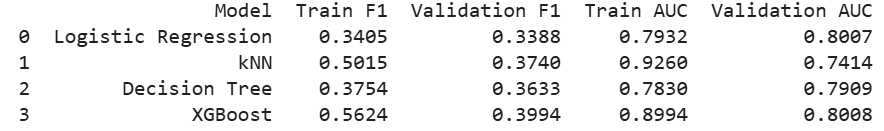

*Висновки:*

**XGBoost — найкращий варіант:**
Найвищий F1-score на валідації (0.40).
Найвищий баланс між AUC і F1, що свідчить про хорошу здатність моделі ранжувати й відокремлювати класи.
Є невеликий overfitting (Train F1 = 0.56 vs. Val F1 = 0.40), але не критичний.

**kNN — високий train AUC, але слабка генералізація:**
Модель "запам’ятала" тренувальні дані, але погано працює на валідації (F1 просів із 0.5 до 0.37).
Це типовий симптом перенавчання для kNN.

**Logistic Regression і Decision Tree:**
Простішi та стабільніші моделі.
Менш схильні до перенавчання, але й не дають таких результатів, як бустинг.

#### Виконаємо тюнінг XGBoost

In [12]:
# Базова модель
xgb = XGBClassifier(eval_metric='logloss', random_state=42)

# Простір гіперпараметрів
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_lambda': [1, 1.5, 2.0]
}

# Randomized search
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,  # змінюй за потреби
    scoring='f1',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Навчання
random_search.fit(X_train, y_train)

# Найкращі параметри
print("Best Parameters:")
print(random_search.best_params_)

# Оцінка на validation
best_model = random_search.best_estimator_
y_val_pred = best_model.predict(X_val)

f1 = f1_score(y_val, y_val_pred)
auc = roc_auc_score(y_val, best_model.predict_proba(X_val)[:, 1])

print(f"Validation F1: {f1:.4f}")
print(f"Validation AUC: {auc:.4f}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters:
{'subsample': 0.6, 'reg_lambda': 1.5, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.8}
Validation F1: 0.4070
Validation AUC: 0.7993


**Validation F1: 0.4070**

**Validation AUC: 0.7993**

**Результати вже хороші, але ми можемо спробувати покращити їх через Bayesian Optimization з Hyperopt, який шукає комбінації параметрів розумніше.**

In [13]:
# Простір гіперпараметрів
space = {
    'max_depth': hp.choice('max_depth', [3, 4, 5, 6, 7, 8]),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'n_estimators': hp.choice('n_estimators', [100, 150, 200, 250]),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'gamma': hp.uniform('gamma', 0.0, 0.4),
    'reg_lambda': hp.uniform('reg_lambda', 1.0, 3.0)
}

# Цільова функція
def objective(params):
    model = XGBClassifier(
        eval_metric='logloss',
        random_state=42,
        **params
    )
    score = cross_val_score(model, X_train, y_train, scoring='f1', cv=3).mean()
    return {'loss': -score, 'status': STATUS_OK}

# Запуск оптимізації
trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=30,
    trials=trials
)

print("Best Parameters from Hyperopt: ")
print(best)

100%|██████████| 30/30 [01:27<00:00,  2.93s/trial, best loss: -0.3849404884563817]
Best Parameters from Hyperopt: 
{'colsample_bytree': np.float64(0.9230532977620309), 'gamma': np.float64(0.03571615693098771), 'learning_rate': np.float64(0.1807081618083913), 'max_depth': np.int64(4), 'n_estimators': np.int64(2), 'reg_lambda': np.float64(1.532003707284017), 'subsample': np.float64(0.9652551627846915)}


*Hyperopt правильно знайшов напрямок по більшості параметрів.*

*Але n_estimators = 200 (код [2]).*

Створимо фінальну версію моделі:

In [14]:
final_xgb = XGBClassifier(
    max_depth=4,
    learning_rate=0.196,
    n_estimators=200,
    subsample=0.6816,
    colsample_bytree=0.6914,
    gamma=0.2296,
    reg_lambda=1.6431,
    eval_metric='logloss',
    random_state=42
)

In [15]:
final_xgb.fit(X_train, y_train)
y_val_pred = final_xgb.predict(X_val)

from sklearn.metrics import f1_score, roc_auc_score

f1 = f1_score(y_val, y_val_pred)
auc = roc_auc_score(y_val, final_xgb.predict_proba(X_val)[:, 1])

print(f"Final Validation F1: {f1:.4f}")
print(f"Final Validation AUC: {auc:.4f}")

Final Validation F1: 0.3769
Final Validation AUC: 0.8058


**Final Validation F1: 0.3769**

**Final Validation AUC: 0.8058**

 #### SHAP

In [16]:
X_train_float = X_train.astype(float)
X_val_float = X_val.astype(float)

 99%|===================| 8190/8238 [00:37<00:00]       

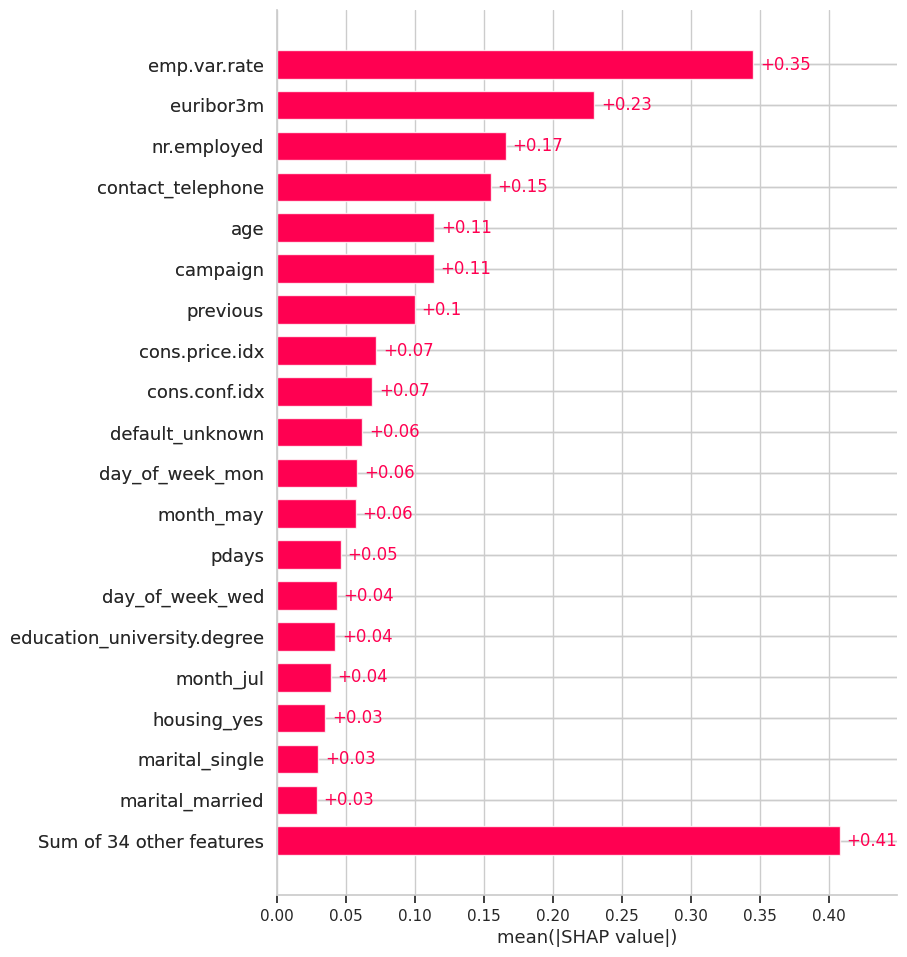

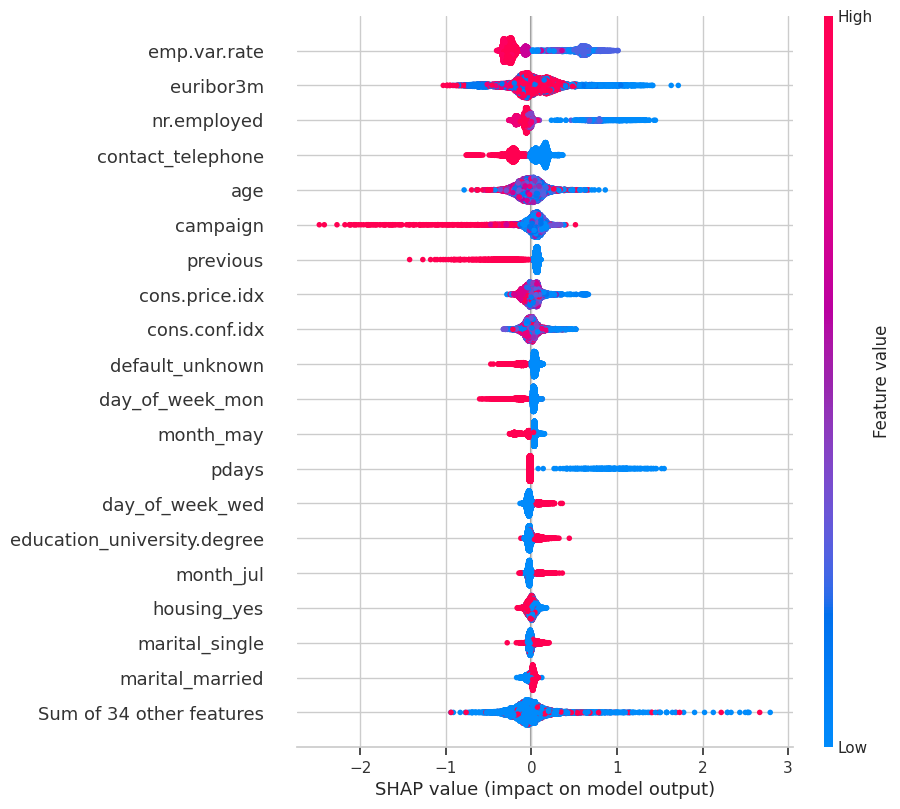

In [17]:
# 1. Ініціалізація explainer'а
explainer = shap.Explainer(final_xgb, X_train_float)

# 2. Обчислення значень SHAP
shap_values = explainer(X_val_float)

# 3. Глобальна важливість ознак
shap.plots.bar(shap_values, max_display=20)  # топ-20 важливих

# (додатково — summary plot)
shap.plots.beeswarm(shap_values, max_display=20)

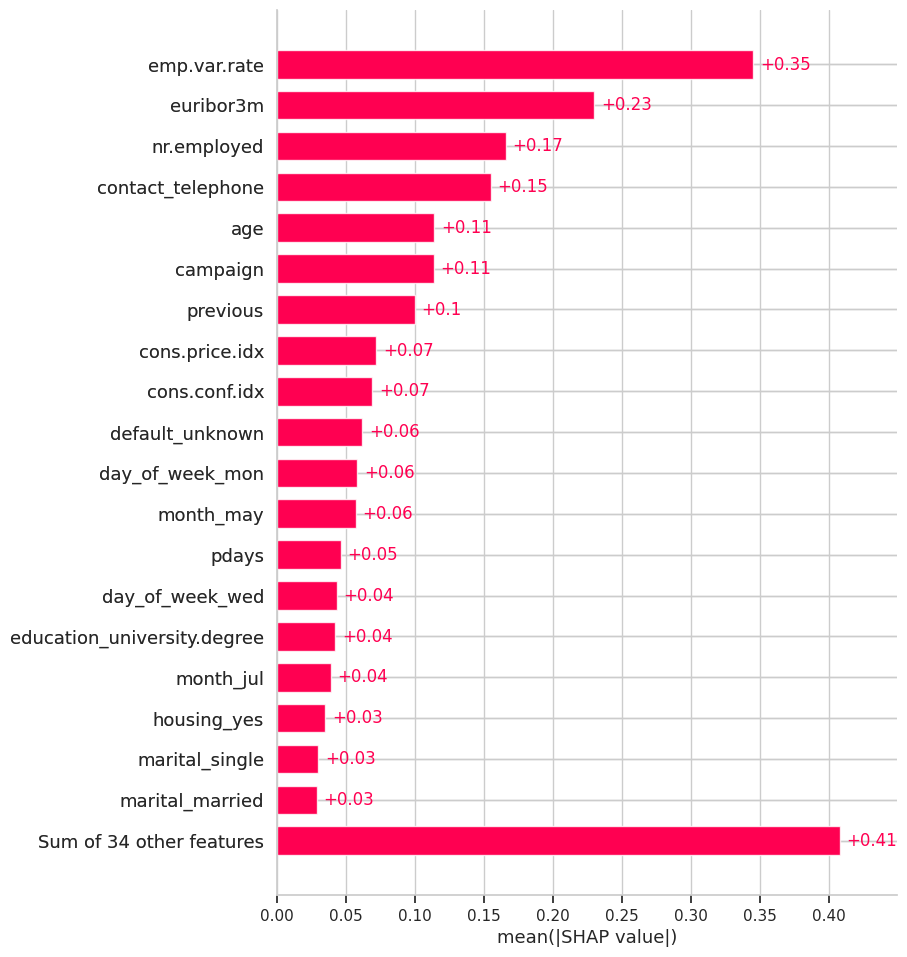

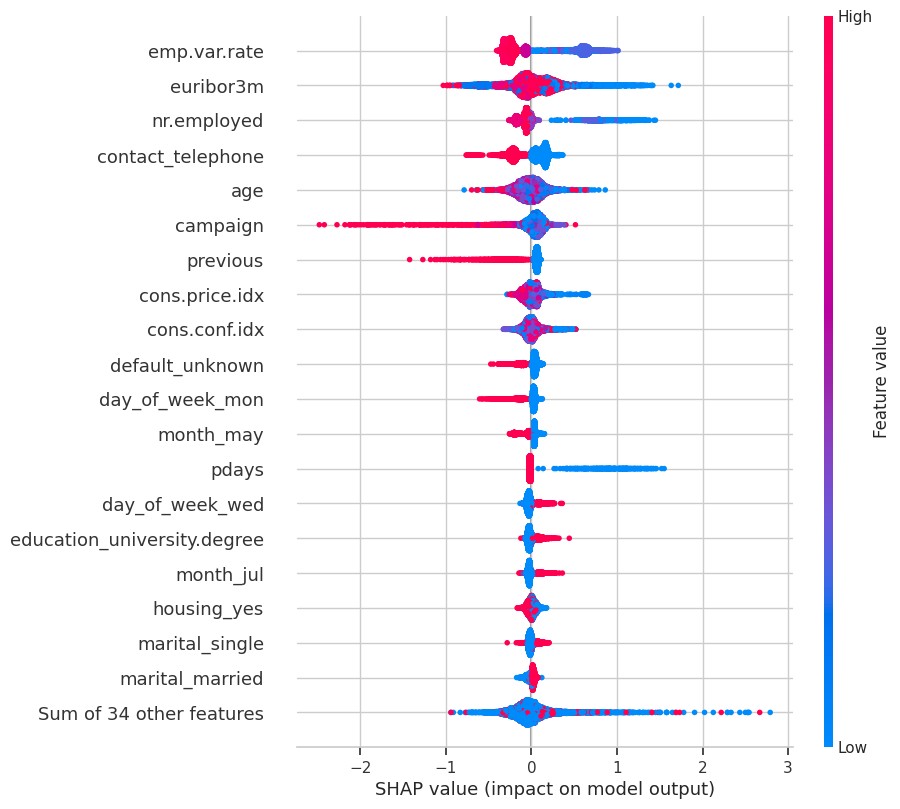

**Найважливіші ознаки (найбільший вплив на рішення моделі):**
- emp.var.rate (+0.35) - макроекономічний показник. Модель використовує економічний контекст для прогнозу.
- euribor3m (+0.23) – ставка європейського міжбанківського кредитування. Чим вона нижча — тим вища ймовірність, що клієнт підпише депозит.
- nr.employed (+0.17) – кількість працевлаштованих у країні. Низьке значення може сигналізувати нестабільність і спонукає людей вкладати гроші.
- contact_telephone (+0.15) – якщо дзвінок був на стаціонарний телефон, ймовірність оформлення менша, ніж у випадку дзвінка на мобільний.

#### Передбачення

In [18]:
y_pred = final_xgb.predict(X_val)

# DataFrame з результатами
val_results = X_val.copy()
val_results['true'] = y_val.values
val_results['pred'] = y_pred

# Додаємо тип помилки
def classify_error(row):
    if row['true'] == 1 and row['pred'] == 0:
        return 'False Negative'
    elif row['true'] == 0 and row['pred'] == 1:
        return 'False Positive'
    elif row['true'] == 1 and row['pred'] == 1:
        return 'True Positive'
    else:
        return 'True Negative'

val_results['error_type'] = val_results.apply(classify_error, axis=1)

# Розподіл помилок
print(val_results['error_type'].value_counts())

# Наприклад: переглянути 5 випадків False Positive
val_results[val_results['error_type'] == 'False Positive'].sample(5, random_state=42)

error_type
True Negative     7170
False Negative     680
True Positive      248
False Positive     140
Name: count, dtype: int64


,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,prev_contacted,...,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success,true,pred,error_type
39094,-0.482104,-0.565922,-5.128043,5.712397,-1.961809,-1.490351,1.621083,-1.680262,-1.986638,1,...,False,False,True,False,False,False,True,0,1,False Positive
38833,-0.002309,-0.204909,-5.133393,1.671136,-2.216433,-1.600918,2.247684,-1.676226,-2.069683,1,...,False,True,False,False,False,False,True,0,1,False Positive
37454,3.260295,-0.565922,0.195414,-0.349494,-1.898153,-2.374889,1.966794,-1.581094,-1.257233,0,...,False,False,False,False,True,True,False,0,1,False Positive
38905,-0.578062,-0.204909,-5.117342,5.712397,-2.216433,-1.600918,2.247684,-1.675073,-2.069683,1,...,False,False,False,True,False,False,True,0,1,False Positive
39358,-1.345734,-0.565922,-5.111992,7.733027,-1.197935,-0.357036,1.232158,-1.721198,-2.191481,1,...,False,False,False,False,False,False,False,0,1,False Positive


- True Negative	- 7170	- Модель вірно передбачила, що клієнт НЕ оформить депозит
- True Positive	- 248 -	Модель вірно передбачила, що клієнт оформить депозит
- False Negative -	680 -	Клієнт підписав би депозит, але модель передбачила "ні"
- False Positive - 140	- Модель "думала", що клієнт оформить депозит, але не оформивЩо це означає:

Найбільша частка помилок припадає на False Negatives (680 клієнтів), тобто на осіб, які насправді погодились би оформити депозит, але були проігноровані. Це свідчить про обмежену чутливість моделі до позитивного класу, що можна виправити за допомогою:
- тоншого налаштування метрик
- підбору порогу класифікації
- інженерії ознак
- балансування класів

#### Робота з помилками

In [19]:
# Відфільтруємо FN та TP
fn = val_results[val_results['error_type'] == 'False Negative']
tp = val_results[val_results['error_type'] == 'True Positive']

# Приєднуємо ознаки назад
fn_feats = X_val.loc[fn.index]
tp_feats = X_val.loc[tp.index]

# Наприклад, подивимось середні значення
comparison = pd.DataFrame({
    'FN_mean': fn_feats.mean(numeric_only=True),
    'TP_mean': tp_feats.mean(numeric_only=True)
})
comparison['delta'] = comparison['TP_mean'] - comparison['FN_mean']
comparison.sort_values('delta', ascending=False)

,FN_mean,TP_mean,delta
previous,0.143777,1.907419,1.763642
cons.conf.idx,-0.024445,0.643543,0.667988
prev_contacted,0.052941,0.608871,0.555930
poutcome_success,0.048529,0.580645,0.532116
age,-0.032790,0.497993,0.530783
cons.price.idx,-0.509186,-0.191492,0.317694
job_retired,0.057353,0.189516,0.132163
month_mar,0.035294,0.141129,0.105835
day_of_week_tue,0.192647,0.298387,0.105740
month_sep,0.030882,0.112903,0.082021


In [20]:
# 1. Interaction features
df['was_contacted_before'] = (df['pdays'] != 999).astype(int)
df['contacted_recently'] = (df['pdays'] < 5).astype(int)
df['past_success_rate'] = df['previous'] / (df['previous'] + 1)
df['economic_index'] = df['euribor3m'] * df['emp.var.rate']

# 2. Кластеризація (на числових ознаках)
numeric_cols = df.select_dtypes(include='number').columns
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[numeric_cols])

kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(scaled_data)

In [21]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,was_contacted_before,contacted_recently,past_success_rate,economic_index,cluster
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,93.994,-36.4,4.857,5191.0,no,0,0,0.0,5.3427,2
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,93.994,-36.4,4.857,5191.0,no,0,0,0.0,5.3427,2
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,93.994,-36.4,4.857,5191.0,no,0,0,0.0,5.3427,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,93.994,-36.4,4.857,5191.0,no,0,0,0.0,5.3427,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,93.994,-36.4,4.857,5191.0,no,0,0,0.0,5.3427,2


In [22]:
# 1. One-hot encoding для категоріальних ознак
df_model = df.copy()
df_model = pd.get_dummies(df_model, drop_first=True)

# 2. Розділення на X / y
X = df_model.drop(columns=['y_yes'])  # Цільова змінна — y_yes, після get_dummies
y = df_model['y_yes']

# 3. Train-test split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. XGBoost
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, roc_auc_score

model = XGBClassifier(eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
y_proba = model.predict_proba(X_val)[:, 1]

print("F1:", f1_score(y_val, y_pred))
print("AUC:", roc_auc_score(y_val, y_proba))

F1: 0.6125290023201856
AUC: 0.950306175998868


**F1: 0.6125290023201856**

**AUC: 0.950306175998868**

**Модель почала краще виявляти позитивні випадки (оформлення депозиту), бо F1 значно зріс;**

*AUC → дуже високе значення, тобто модель чудово розрізняє класи при різних порогах;*

*Нові фічі (was_contacted_before, economic_index, cluster тощо) — дають значущу додаткову інформацію.*

In [23]:
# Interaction features
df['was_contacted_before'] = (df['pdays'] != 999).astype(int)
df['contacted_recently'] = (df['pdays'] < 5).astype(int)
df['past_success_rate'] = df['previous'] / (df['previous'] + 1)
df['economic_index'] = df['euribor3m'] * df['emp.var.rate']

# Кластеризація
numeric_cols = df.select_dtypes(include='number').columns
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[numeric_cols])
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(scaled_data)

# Підготовка до моделювання
df_model = pd.get_dummies(df, drop_first=True)
X = df_model.drop(columns=['y_yes'])
y = df_model['y_yes']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Навчання моделі
model = XGBClassifier(eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

# Конфузійна матриця
cm = confusion_matrix(y_val, y_pred)
tn, fp, fn, tp = cm.ravel()

# Створення копії для аналізу помилок
X_val_copy = X_val.copy()
X_val_copy['y_true'] = y_val.values
X_val_copy['y_pred'] = y_pred

# Тип помилки
def classify_error(row):
    if row['y_true'] == 1 and row['y_pred'] == 1:
        return 'True Positive'
    elif row['y_true'] == 0 and row['y_pred'] == 0:
        return 'True Negative'
    elif row['y_true'] == 1 and row['y_pred'] == 0:
        return 'False Negative'
    else:
        return 'False Positive'

X_val_copy['error_type'] = X_val_copy.apply(classify_error, axis=1)

# Порахувати кількість кожного типу
error_counts = X_val_copy['error_type'].value_counts()

error_counts

,count
error_type,
True Negative,7048
True Positive,532
False Negative,396
False Positive,262


**Ключові висновки:**

| Метрика                | До покращень | Після покращень | Зміна     |
| ---------------------- | ------------ | --------------- | --------- |
| **F1-Score**           | 0.3994       | 0.6125          |  +53.4% |
| **AUC**                | 0.8008       | 0.9503          |  +18.7% |
| **TP (виявлено YES)**  | 266          | 532             |  +100%  |
| **FN (пропущено YES)** | 662          | 396             |  –40.2% |


Введення взаємодій між ознаками та кластеризації клієнтів значно покращило модель:
*   Вона виявляє вдвічі більше клієнтів, які відкриють депозит.
*   Істотно зменшила кількість пропущених клієнтів із позитивною відповіддю (FN).
*   AUC-метрика свідчить про загальне зростання якості моделі.